This is a notebook to compute the true positive rates for predicting insolubility using MD data, using conditional probabilities

In [1]:
import os
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import itertools
import matplotlib.gridspec as gridspec

%matplotlib inline
%reload_ext autoreload
%autoreload 2

#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, plot_roc_curve

#from mlxtend.data import iris_data # I don't have this installed
from sklearn.utils import resample

import os
import math
from math import floor, ceil

from six import StringIO
#from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
#import pydotplus # don't have installed 

In [11]:
#dataFile = "/home/pkekeneshuskey/DL/features-latest-sets1n2.txt"
dataFile = "feature_sets/features-latest-sets1n2.txt"

df = pd.read_csv(dataFile, sep="\s+", comment='#')
df.head()

,VARIANT,HELIX,TURNS,COILS,THREE-TEN,BETA,ISOLATED,RMSD,HBONDS,SASA,WATERS,FOLDX,CONSERVATION,HYDROPHOBICITY,CLASS,TRAFFICKING
0,a32t,21.1567,21.2058,14.4202,3.29401,39.6439,0.279349,1.23560,66.7186,6473.83,1479.93,3.763310,-0.549,-0.43,1,1
1,a57p,20.4290,21.8332,14.5935,3.53135,39.4690,0.144014,1.28151,66.0936,6477.76,1526.79,-0.764827,-0.312,-0.32,0,1
2,a78p,20.8206,21.3096,14.5379,3.19232,39.9190,0.220522,1.12505,65.8526,6479.56,1474.41,0.759351,1.487,-0.32,1,1
3,a85v,20.8686,21.4237,14.6775,3.12031,39.6774,0.232523,1.16450,65.4562,6544.62,1492.34,2.430410,-0.518,0.29,1,1
4,c108r,22.1452,21.1476,15.3975,2.75727,38.2283,0.324033,1.58552,62.7131,6753.12,1548.93,6.958320,0.745,-1.84,1,0


- First print all column headers so you can select which ones you want to use for analysis
- Select subset you want to use

In [12]:
# get list of features
for col in df.columns:
    print(col)
    

tags = ['RMSD','HBONDS','WATERS','SASA','HELIX','TURNS','COILS','BETA','THREE-TEN','FOLDX','CONSERVATION','HYDROPHOBICITY']    
#tags = ['RMSD']

VARIANT
HELIX
TURNS
COILS
THREE-TEN
BETA
ISOLATED
RMSD
HBONDS
SASA
WATERS
FOLDX
CONSERVATION
HYDROPHOBICITY
CLASS
TRAFFICKING


In [13]:
import dataUtil as dU

RMSD 0.125 0.43283582089552236 75.0 dRMSD
HBONDS 0.4666666666666667 0.13333333333333333 75.0 -1 x dHBONDS
WATERS 0.14285714285714285 0.4264705882352941 75.0 dWATERS
SASA 0.35384615384615387 0.7 75.0 dSASA
HELIX 0.5714285714285714 0.38235294117647056 75.0 -1 x dHELIX
TURNS 0.2833333333333333 0.8666666666666667 75.0 dTURNS
COILS 0.2558139534883721 0.59375 75.0 dCOILS
BETA 0.4027777777777778 0.3333333333333333 75.0 -1 x dBETA
THREE-TEN 0.3898305084745763 0.4375 75.0 dTHREE-TEN
FOLDX 0.09090909090909091 0.453125 75.0 dFOLDX
CONSERVATION 0.42592592592592593 0.3333333333333333 75.0 -1 x dCONSERVATION
HYDROPHOBICITY 0.3181818181818182 0.5161290322580645 75.0 dHYDROPHOBICITY


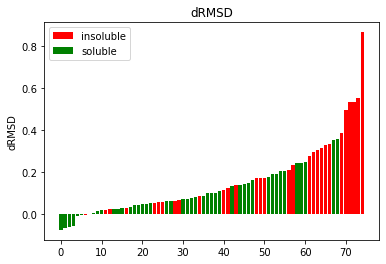

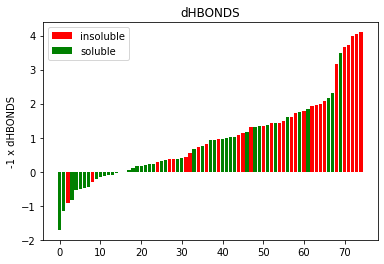

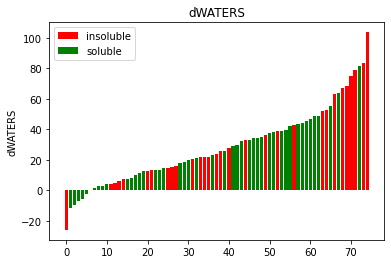

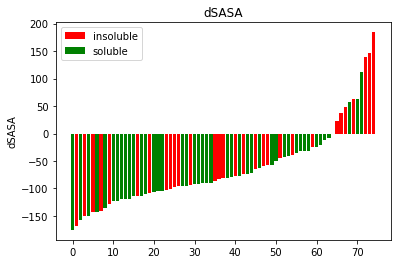

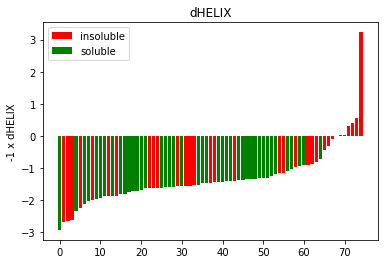

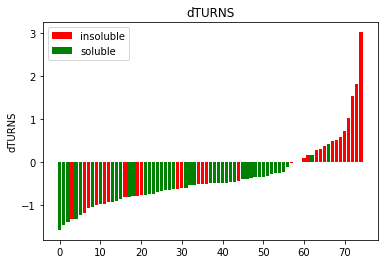

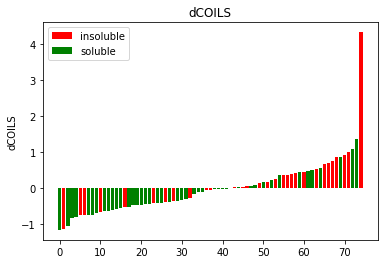

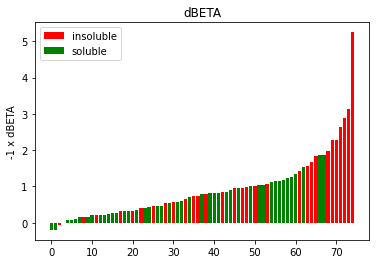

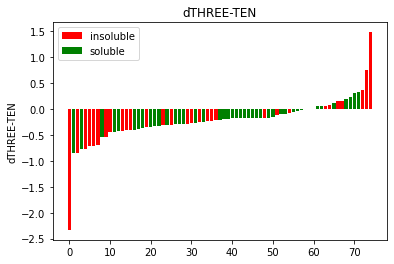

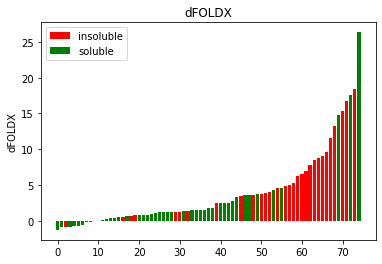

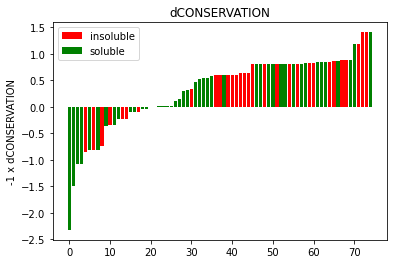

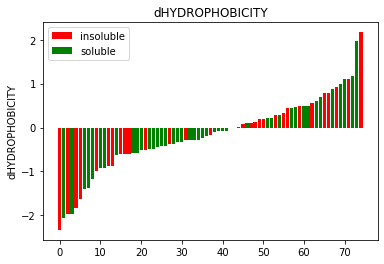

In [14]:
display=True
wtName = "wt"

for tag in tags:
    dU.ShapeData(df,tag,wtName,display=display)

In [15]:
dTags = ["d"+t for t in tags]
print(dTags)

['dRMSD', 'dHBONDS', 'dWATERS', 'dSASA', 'dHELIX', 'dTURNS', 'dCOILS', 'dBETA', 'dTHREE-TEN', 'dFOLDX', 'dCONSERVATION', 'dHYDROPHOBICITY']


Computes 
$P(Insol | feature > \lambda)$
and 
$\Pi P(Insol | feature_i > \lambda)$

I've verified that I am computing the correct conditional probability for each feature and variant


* Note: adjust the value_variant-value_wt order to make sure all plots are roughly monotonically increasing * 

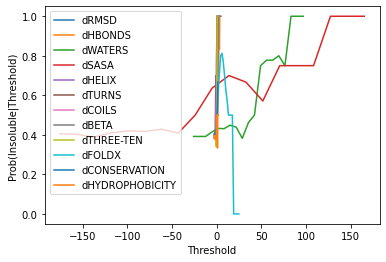

In [16]:
tagsSubset = dTags  # replace with tags = ['dRMSD','dHBONDS','dWATERS'] if want to use smaller feature set


df_train = df
dU.ProdCondProbs(dTags,df,df_train,display=True)
    

The product of conditional probabilities gives the likelihood that a member is defective (insoluble), given the products of being insoluble for each feature.
We then pick a 'reasonable' threshold to decide if a member is insoluble

In [17]:
#dummy = calcRates(df,cutoff=0.15)
df_test = df
dummy = dU.calcRates(df_test,cutoff=None)

Cutoff  0.5
TPR (insol) 1.0  Support  1
FNR (insol) 0.3918918918918919  Support  29


{'cutoffs': array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ,
        1.        ]),
 'tprs': array([0.4       , 0.875     , 0.85714286, 0.85714286, 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        ]),
 'fprs': array([0.6       , 0.125     , 0.14285714, 0.14285714, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]),
 'tnrs': array([1.        , 0.72881356, 0.64705882, 0.64705882, 0.64285714,
        0.625  

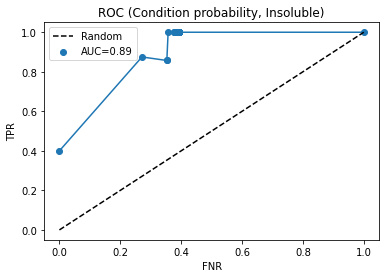

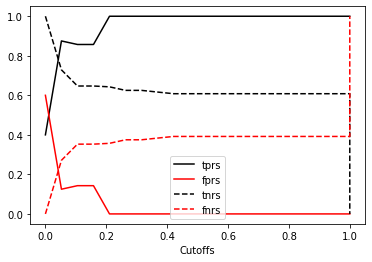

In [18]:
dU.ComputeROC(df)